In [37]:
# https://www.kaggle.com/kukuroo3/used-car-price-dataset-competition-format
#  !kaggle --version
# !kaggle --help
# !kaggle datasets download -d kukuroo3/used-car-price-dataset-competition-format
# !unzip used-car-price-dataset-competition-format.zip
# !rm used-car-price-dataset-competition-format.zip
# !kaggle competitions submit -c kukuroo3/used-car-price-dataset-competition-format -f submission.csv -m "HoGent"

In [38]:
import numpy as np
import pandas as pd
import seaborn as sns
import autosklearn
from autosklearn.regression import AutoSklearnRegressor
from sklearn.model_selection import train_test_split

In [39]:
# def check_differences(X, X_sub):
#   differences = (X.columns).difference(X_sub.columns)
#   for column in differences:
#     if (column not in X.columns):
#       print("'{column}' is not in 'X'. Dropping it from 'X_sub'".format(column= column))
#       X_sub.drop([column], axis=1, inplace=True)
#     if (column not in X_sub.columns):
#       print("'{column}' is not in 'X_sub'. I'll add it with value equals to '0'".format(column= column))
#       X_sub[column] = 0

# X, y, X_sub, y_sub
def clean_and_train_test_split(df_train, df_val):
  def strip_columns(df, columns):
    for item in columns:
      df[item] = df[item].apply(lambda x: x.strip())
      df[item] = df[item].apply(lambda x: x.replace(" ",""))
      return df

  def get_dummies(df, columns):
    df = pd.get_dummies(df, columns=columns)
    return df
  
  columns=["brand", "model", "transmission", "fuelType"]

  X = df_train.drop(['carID'], axis="columns")
  X = strip_columns(X, columns)
  X = get_dummies(X, columns)

  y = X['price']

  carID = df_val['carID']
  X_val = df_val.drop(['carID'], axis="columns")
  X_val = strip_columns(X_val, columns)
  X_val = get_dummies(X_val, columns)
  
  y_val = X_val['price']
  
  # check_differences(X, X_sub)
  differences = (X.columns).difference(X_val.columns)
  for column in differences:
    if (column not in X.columns):
      print("'{column}' is not in 'X'. Dropping it from 'X_val'".format(column= column))
      X_val.drop([column], axis=1, inplace=True)
    if (column not in X_val.columns):
      print("'{column}' is not in 'X_val'. I'll add it with value equals to '0'".format(column= column))
      X_val[column] = 0

  X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state=42)
  X_train = X_train.reindex(sorted(X_train.columns), axis=1)
  X_test = X_test.reindex(sorted(X_test.columns), axis=1)
  X_val = X_val.reindex(sorted(X_val.columns), axis=1)

  return X_train, X_test, y_train, y_test, X_val, y_val, carID


In [40]:
# X = pd.read_csv("X_train.csv")
df_X_train = pd.read_csv("X_train.csv")
df_y_train = pd.read_csv("y_train.csv")
df_train = pd.merge(df_X_train, df_y_train, left_on='carID', right_on='carID', how='left')
# X['price'] = y['price']

df_X_val = pd.read_csv("X_test.csv")
df_y_val = pd.read_csv("test_label/Y_test.csv")
df_val = pd.merge(df_X_val, df_y_val, left_on='carID', right_on='carID', how='left')


df_val.head()


,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,12000,merc,GLS Class,2017,Automatic,12046,Diesel,150.0,37.2,3.0,38000
1,12001,vw,Amarok,2017,Automatic,37683,Diesel,260.0,36.2,3.0,23495
2,12004,merc,GLS Class,2019,Automatic,10000,Diesel,145.0,34.0,3.0,59999
3,12013,skoda,Scala,2019,Manual,3257,Petrol,145.0,49.6,1.0,16713
4,12017,audi,RS6,2015,Semi-Auto,20982,Petrol,325.0,29.4,4.0,46000


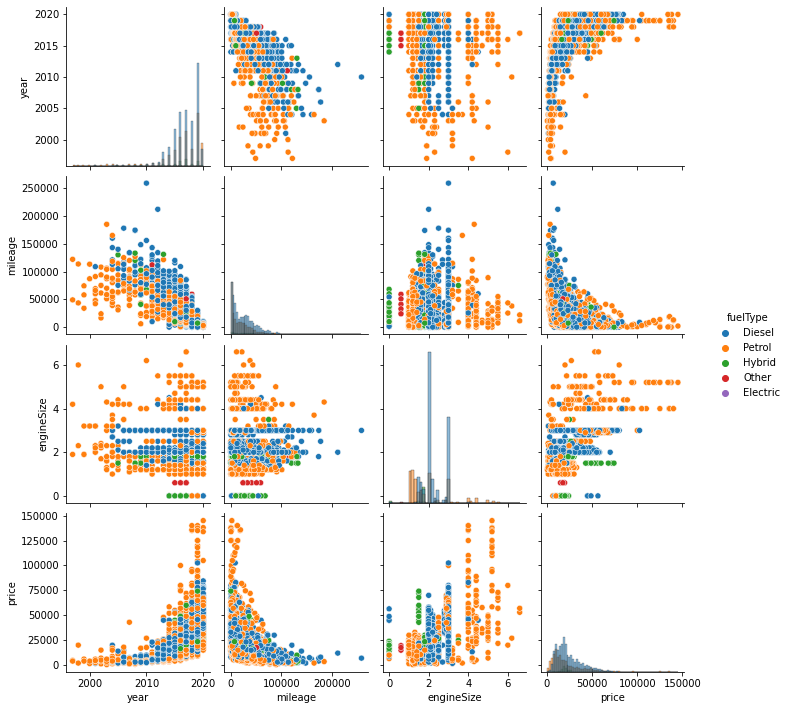

In [41]:
plot = sns.pairplot(
  df_train,
  # hue="brand",
  hue="fuelType",
  # diag_kind="kde",
  diag_kind="hist",
  x_vars=["year", "mileage", "engineSize", "price"],
  y_vars=["year", "mileage", "engineSize", "price"],
  # corner=True
);
# plot.map_lower(sns.kdeplot, levels=4, color=".2")


In [42]:
X_train, X_test, y_train, y_test, X_val, y_val, carID = clean_and_train_test_split(df_train, df_val)

X_train.info()
X_test.info()
X_val.info()

'model_ M6' is not in 'X_val'. I'll add it with value equals to '0'
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3472 entries, 1909 to 860
Columns: 114 entries, brand_audi to year
dtypes: float64(3), int64(3), uint8(108)
memory usage: 556.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1488 entries, 3135 to 1943
Columns: 114 entries, brand_audi to year
dtypes: float64(3), int64(3), uint8(108)
memory usage: 238.3 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2672 entries, 0 to 2671
Columns: 114 entries, brand_audi to year
dtypes: float64(3), int64(4), uint8(107)
memory usage: 446.2 KB


In [43]:
def get_and_fit_model(X_train, y_train, dataset_name, time_left_for_this_task=30, per_run_time_limit=10):
  model = AutoSklearnRegressor(
    # time_left_for_this_task=30,
    # per_run_time_limit=10
    time_left_for_this_task=time_left_for_this_task,
    per_run_time_limit=per_run_time_limit
  )
  model.fit(X_train, y_train, dataset_name=dataset_name)
  return model

In [44]:
model = get_and_fit_model(X_train, y_train, dataset_name="UsedCarPrice", time_left_for_this_task=120, per_run_time_limit=30)
# model = get_and_fit_model(X_train, y_train, dataset_name="UsedCarPrice", time_left_for_this_task=30, per_run_time_limit=10)

In [45]:
def get_scores_and_predictions(model, X_train, y_train, X_test, y_test, X_sub):
  training_score = model.score(X_train, y_train)
  testing_score = model.score(X_test, y_test)
  test_predictions = model.predict(X_test)
  predictions = model.predict(X_sub)
  return training_score, testing_score, test_predictions, predictions

In [46]:
training_score, testing_score, test_predictions, predictions = get_scores_and_predictions(model, X_train, y_train, X_test, y_test, X_val)
print("training_score: {training_score}".format(training_score=training_score))
print("testing_score: {testing_score}".format(testing_score=testing_score))
print("test_predictions: {test_predictions}".format(test_predictions=test_predictions))
print("predictions: {predictions}".format(predictions=predictions))

training_score: 0.9997784238195022
testing_score: 0.9989334899119373
test_predictions: [20499.40234375 15223.39257812 18455.10351562 ... 15498.92773438
 28999.08007812 25577.29882812]
predictions: [37989.         23492.77539062 60029.8046875  ... 21994.56054688
 18696.45898438  2976.97851562]


In [47]:
X_test.head()

,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,engineSize,...,model_ i3,model_ i8,mpg,price,tax,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,year
3135,0,0,1,0,0,0,0,0,0,2.0,...,0,0,48.7,20500,165.0,1,0,0,0,2017
2191,0,1,0,0,0,0,0,0,0,2.0,...,0,0,54.3,15199,145.0,1,0,0,0,2015
1295,0,1,0,0,0,0,0,0,0,3.0,...,0,0,51.4,18450,160.0,1,0,0,0,2016
2902,0,0,0,0,1,0,0,0,0,3.0,...,0,0,41.5,12995,235.0,1,0,0,0,2012
168,0,0,0,0,1,0,0,0,0,2.1,...,0,0,48.7,19750,145.0,1,0,0,0,2018


In [48]:
y_test.head()
y_test.info()

AttributeError: 'Series' object has no attribute 'info'

In [ ]:
test_predictions.size
print(type(pd.DataFrame(test_predictions)))
print(type(y_test['price'].array))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.arrays.numpy_.PandasArray'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
def get_metrics(y_test, test_predictions):
  # print(autosklearn.metrics.REGRESSION_METRICS)
  mean_squared_error=autosklearn.metrics.mean_squared_error(y_test, test_predictions)
  MSE = np.mean((y_test - test_predictions) ** 2)
  mean_absolute_error=autosklearn.metrics.mean_absolute_error(y_test, test_predictions)
  MAE = np.mean(np.absolute(y_test - test_predictions))
  r2=autosklearn.metrics.r2(y_test, test_predictions)
  return mean_squared_error, MSE, mean_absolute_error, MAE, r2


In [ ]:
mean_squared_error, MSE, mean_absolute_error, MAE, r2 = get_metrics(np.array(y_test['price']), np.array(test_predictions))
# np.mean((np.array(y_test['price']) - np.array(test_predictions)) ** 2)
print("mean_squared_error: {mean_squared_error}".format(mean_squared_error=mean_squared_error))
print("MSE: {MSE}".format(MSE=MSE))
print("mean_absolute_error: {mean_absolute_error}".format(mean_absolute_error=mean_absolute_error))
print("MAE: {MAE}".format(MAE=MAE))
print("r2: {r2}".format(r2=r2))

mean_squared_error: -19421417.87347351
MSE: 19421417.87347351
mean_absolute_error: -2379.949525033274
MAE: 2379.949525033274
r2: 0.9293622735501866
